In [1]:
# Parte 1 - creo dataframe
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
from MJP.majority_portfolio_utilities_TV import * 

FILENAME = 'monthly_data.csv'
factors_df=pd.DataFrame({
    'factors': ['ag','beta','bm','cumret','dolvol6','gp','ill6','ns','size','volatility','acc'],
    'signs': [  -1.,  1.,   1.,    1.,     -1.,     1.,    1.,  -1.,  -1.,   -1.,   -1.],
    'wsigns':[  -1.,  1.,   1.,    1.,     -1.,     1.,    1.,  -1.,  -1.,   -1.,   -1.]
})

DATA_INIZIO = '2000-01-01'
DATA_FINE = '2023-12-31'

df = create_df(FILENAME, factors_df['factors'].tolist(), DATA_INIZIO, DATA_FINE) # funzione sua
df['date']=pd.to_datetime(df['date']) 
print(f"DataFrame caricato: {df.shape[0]:,} righe, {df.shape[1]} colonne")
print(df.columns.tolist())

DataFrame caricato: 1,099,846 righe, 19 colonne
['PERMNO', 'date', 'RET', 'ns', 'me', 'size', 'me_lag', 'ag', 'gp', 'acc', 'bm', 'RF', 'Mkt_RF', 'RET_RF', 'cumret', 'dolvol6', 'ill6', 'volatility', 'beta']


In [2]:
# PARTE 2 - NORMALIZZO CON QUANTILE NORMALIZER

from sklearn.preprocessing import QuantileTransformer

factors_to_normalize = ['ns', 'size', 'ag', 'gp', 'acc', 'bm', 'ill6', 'volatility', 'beta']

# Elimina righe con NaN solo nelle colonne da normalizzare
df_clean = df.dropna(subset=factors_to_normalize)

# Applica Quantile normalization solo ai fattori
scaler = QuantileTransformer(output_distribution='uniform', random_state=0)
df_norm = df_clean.copy()
df_norm[factors_to_normalize] = scaler.fit_transform(df_clean[factors_to_normalize])

print("✅ df normalizzato su fattori:")
df_norm.head()

✅ df normalizzato su fattori:


,PERMNO,date,RET,ns,me,size,me_lag,ag,gp,acc,bm,RF,Mkt_RF,RET_RF,cumret,dolvol6,ill6,volatility,beta
0,10001,2000-01-31,-0.044118,0.552123,19.90625,0.089730,20.82500,0.429226,0.186763,0.098351,0.751966,0.0041,-0.0474,-0.048218,-0.066220,3862.520833,0.868132,0.039530,0.100142
1,10001,2000-02-29,0.015385,0.552123,20.21250,0.090958,19.90625,0.429226,0.186763,0.098351,0.746500,0.0043,0.0245,0.011085,-0.018159,3476.520833,0.875944,0.018688,0.100379
2,10001,2000-03-31,-0.015758,0.619632,19.71200,0.088813,20.21250,0.429226,0.186763,0.098351,0.754909,0.0047,0.0520,-0.020458,-0.015986,3445.854167,0.864058,0.018764,0.102204
3,10001,2000-04-30,0.011719,0.619632,19.94300,0.089905,19.71200,0.429226,0.186763,0.098351,0.751315,0.0046,-0.0640,0.007119,-0.045133,3282.276042,0.822586,0.018568,0.096001
4,10001,2000-05-31,-0.023166,0.619632,19.48100,0.087670,19.94300,0.429226,0.186763,0.098351,0.759141,0.0050,-0.0442,-0.028166,-0.013093,2921.385417,0.850747,0.018772,0.100983


In [3]:
# Parte 3 - inizializzazione della configurazione

# *** ATTENZIONE *** --> PRIMA MODIFICA, HO MESSO TRUE A WEIGHT

remove_outliers = False
inf, sup = None, None
MJ_configuration={
    'K' : 12, # holding_periods in months
    'lag' : 5, # 5 for june reallocation
    'factors' : factors_df['factors'].to_list(),
    'num_port' : 10, # number of portfolios
    'num_cat' : 6, # number of categorical variables to use per factor in mj #'num_cat': 6
    'weighting': True,
    'verbose': True,
    'n_jobs':-1,
    'mj_window':1,
    'method' : 'majority', # mean_rank, majority, 75q, 90q, lex, dlex
    'rolling_method':'profile',  ###'rank','vote','profile'
    'treat_na_mj':'median',
    'remove_outliers':remove_outliers,
    'inclusive':True,
    'fix_signs':True, # True: tieni fisso il numero di votanti ed il loro segno
    'all_voters_not_nan_on_reallocation':True,
    #### PARAMETRI UTILIZZATI SOLO SE fix_signs=False ####
    'min_voters':5,    
    'voting_window':6,
    'sign_voting_window':12,
    'p_threshold' : 0.1, 
    'delta_utility' : 0,
    'eliminations': 1,
    'players_batch_size': 5,
    'small': True
}
if remove_outliers:
    MJ_configuration['outliers']=[inf,sup]

if MJ_configuration['weighting']:
    MJ_configuration['default_voters']=factors_df['factors'].to_list()
    MJ_configuration['default_signs']=factors_df['wsigns'].to_list()
    compute='wmj'
elif not MJ_configuration['weighting']:
    MJ_configuration['default_voters']=factors_df['factors'].to_list()
    MJ_configuration['default_signs']=factors_df['signs'].to_list()
    compute='mj'

factors=factors_df['factors'].to_list() # salva separatamente la lista dei nomi dei fattori 

In [4]:
# Parte 4 - creazione portafogli single criteria e MJ

### COMPUTE SINGLE FACTOR STRATEGIES
portfolios, weighted_portfolios, portfolios_stock_reallocation = compute_factor_strategies(df_norm, MJ_configuration)
        # '2020-06-30': [list of tickers]       # Con pesi, uguale ma 'AAPL': 0.1           # 'AAPL': 2020-06-30': 'P3', '2021-06-30': 'P5'}
        # '2021-06-30': [list of tickers]
        # _ perché non considero weighted_portfolios al momento

### COMPUTE EQUAL WEIGHTED MJ STRATEGY
MJ_configuration['weighting']=False
MJ_portfolios, \
mj_voters, \
MJ_portfolios_stock_reallocation = compute_MJ_portfolio_strategy(df_norm, MJ_configuration)

portfolios['mj'] = MJ_portfolios['mj']
portfolios_stock_reallocation['mj'] = {}
portfolios_stock_reallocation['mj']['EW_turnover'] = MJ_portfolios_stock_reallocation['mj']

### COMPUTE VALUE WEIGHTED MJ STRATEGY
MJ_configuration['weighting']=True
MJ_weighted_portfolios, \
mj_voters, \
MJ_weighted_portfolios_stock_reallocation = compute_MJ_portfolio_strategy(df_norm, MJ_configuration)

weighted_portfolios['wmj'] = MJ_weighted_portfolios['wmj']
portfolios_stock_reallocation['wmj'] = {}
portfolios_stock_reallocation['wmj']['VW_turnover'] = MJ_weighted_portfolios_stock_reallocation['wmj']

'''
OUTPUT: 
portfolios = {
  'ns': DataFrame con port1...port10 costruiti su ns,
  'beta': ...,
  'bm': ...,
  ...
  'mj': DataFrame con port1...port10 creati con MJ
}
'''


"\nOUTPUT: \nportfolios = {\n  'ns': DataFrame con port1...port10 costruiti su ns,\n  'beta': ...,\n  'bm': ...,\n  ...\n  'mj': DataFrame con port1...port10 creati con MJ\n}\n"

<Axes: xlabel='medate'>

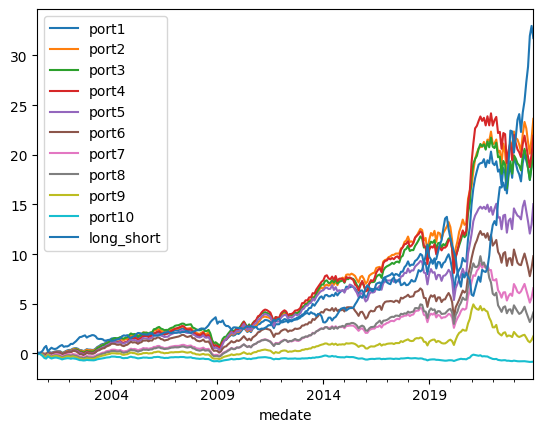

In [5]:
# Parte 5 - plotto
# single criteria

import matplotlib.pyplot as plt

factor='ns'                                     # NS casuale, potremmo usare altro
((1+portfolios[factor]).cumprod()-1).plot()


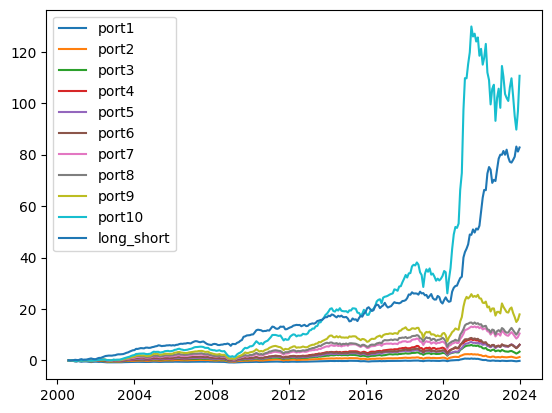

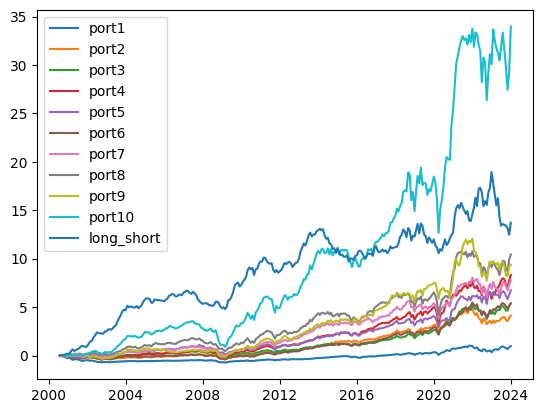

In [6]:
# Plot cumulative returns of EW MJ portfolios 
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+portfolios['mj'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

# Plot cumulative returns of VW MJ portfolios 
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+weighted_portfolios['wmj'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

In [7]:
# PARTE 6 - COMPUTE EW-VW MCDM STRATEGY

TOPSIS_portfolios, TOPSIS_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'topsis', MJ_configuration, weighting=False)
VIKOR_portfolios, VIKOR_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'vikor', MJ_configuration, weighting=False)
PROMETHEE_portfolios, PROMETHEE_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'promethee', MJ_configuration, weighting=False)

# inserisco EW mcdm in portfolios e reallocation
portfolios['topsis'] = TOPSIS_portfolios # gia' df
portfolios['vikor'] = VIKOR_portfolios
portfolios['promethee'] = PROMETHEE_portfolios

portfolios_stock_reallocation['topsis'] = TOPSIS_portfolios_stock_reallocation
portfolios_stock_reallocation['vikor'] = VIKOR_portfolios_stock_reallocation
portfolios_stock_reallocation['promethee'] = PROMETHEE_portfolios_stock_reallocation

### COMPUTE VW MCDM STRATEGY
TOPSIS_weighted_portfolios, TOPSIS_weighted_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'topsis', MJ_configuration, weighting=True)
VIKOR_weighted_portfolios, VIKOR_weighted_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'vikor', MJ_configuration, weighting=True)
PROMETHEE_weighted_portfolios, PROMETHEE_weighted_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'promethee', MJ_configuration, weighting=True)

# inserisco VW mcdm in portfolios e reallocation
weighted_portfolios['wtopsis'] = TOPSIS_weighted_portfolios
weighted_portfolios['wvikor'] = VIKOR_weighted_portfolios
weighted_portfolios['wpromethee'] = PROMETHEE_weighted_portfolios

portfolios_stock_reallocation['wtopsis'] = TOPSIS_weighted_portfolios_stock_reallocation
portfolios_stock_reallocation['wvikor'] = VIKOR_weighted_portfolios_stock_reallocation
portfolios_stock_reallocation['wpromethee'] = PROMETHEE_weighted_portfolios_stock_reallocation


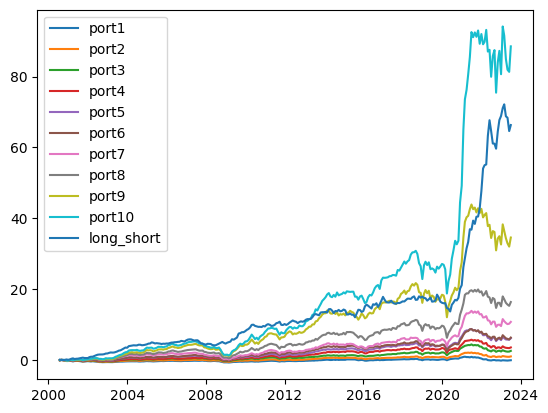

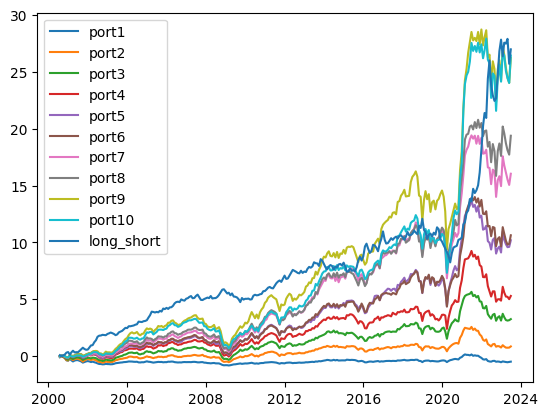

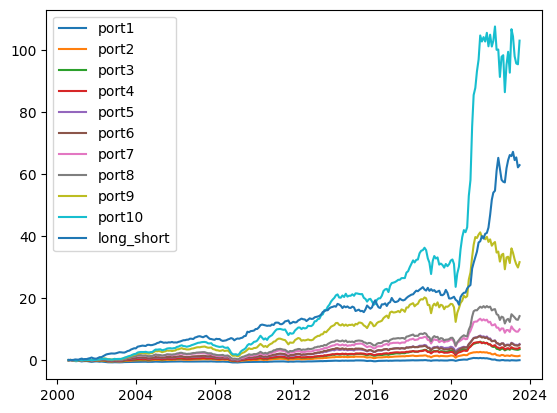

In [8]:
# PARTE 7 - plot degli mcdm
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+portfolios['topsis'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

# vikor
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+portfolios['vikor'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

# promethee
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+portfolios['promethee'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

In [35]:
metodi = list(portfolios.keys())

best_portfolios = {}

print("Studio dei rendimenti nei portafogli *EW*")
for metodo in metodi:
    df_metodo = portfolios[metodo]
    rendimenti_medi = df_metodo.mean()
    best_port = rendimenti_medi.idxmax()
    best_rendimento = rendimenti_medi.max()

    best_portfolios[metodo] = {
        'portafoglio': best_port,
        'rendimento_medio': best_rendimento
    }

for metodo, info in best_portfolios.items():
    print(f"{metodo.upper():<10} --> {info['portafoglio']} con rendimento medio {info['rendimento_medio']:.4f}")

# Trova il miglior portafoglio tra tutti quelli già salvati
migliore_assoluto = max(best_portfolios.items(), key=lambda x: x[1]['rendimento_medio'])

metodo_top = migliore_assoluto[0]
portafoglio_top = migliore_assoluto[1]['portafoglio']
rendimento_top = migliore_assoluto[1]['rendimento_medio']
print("*" * 50)
print(f"WINNER: Il miglior portafoglio EW in assoluto è: {metodo_top.upper()} ➜ {portafoglio_top} con rendimento medio {rendimento_top:.4f}")

Studio dei rendimenti nei portafogli *EW*
AG         --> port3 con rendimento medio 0.0132
BETA       --> port7 con rendimento medio 0.0113
BM         --> port10 con rendimento medio 0.0180
CUMRET     --> port1 con rendimento medio 0.0122
DOLVOL6    --> port1 con rendimento medio 0.0191
GP         --> port10 con rendimento medio 0.0128
ILL6       --> port10 con rendimento medio 0.0181
NS         --> long_short con rendimento medio 0.0143
SIZE       --> port1 con rendimento medio 0.0166
VOLATILITY --> port6 con rendimento medio 0.0113
ACC        --> port7 con rendimento medio 0.0109
MJ         --> port10 con rendimento medio 0.0194
TOPSIS     --> port10 con rendimento medio 0.0189
VIKOR      --> port9 con rendimento medio 0.0140
PROMETHEE  --> port10 con rendimento medio 0.0191
ADDDEA     --> port2 con rendimento medio 0.0158
**************************************************
WINNER: Il miglior portafoglio EW in assoluto è: MJ ➜ port10 con rendimento medio 0.0194


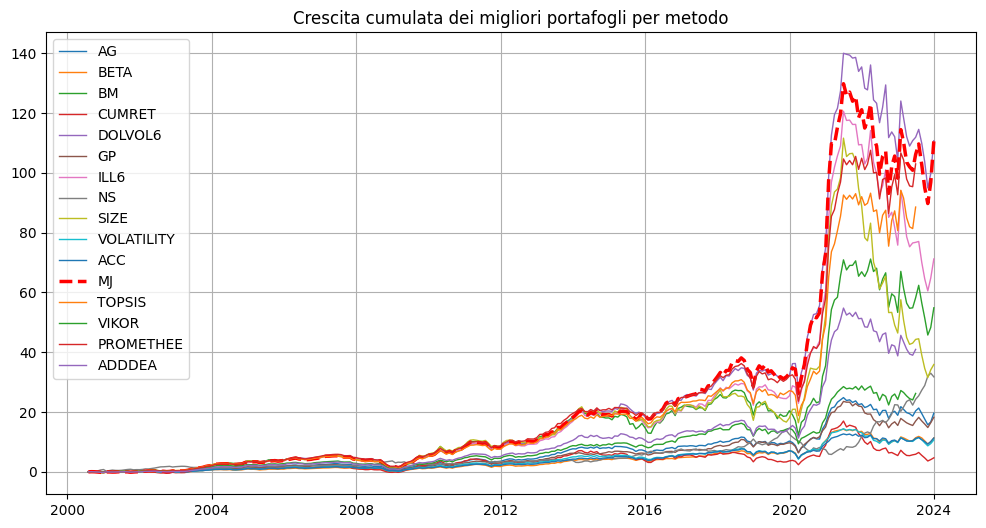

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for metodo, info in best_portfolios.items():
    serie = portfolios[metodo][info['portafoglio']]
    crescita = (1 + serie).cumprod() - 1

    if metodo.lower() == 'mj':
        plt.plot(crescita, label=metodo.upper(), color='red', linewidth=2.5, linestyle='--')
    else:
        plt.plot(crescita, label=metodo.upper(), linewidth=1)

plt.legend()
plt.title('Crescita cumulata dei migliori portafogli per metodo')
plt.grid(True)
plt.show()


In [24]:
metodi_w = list(weighted_portfolios.keys())

best_wportfolios = {}

print("Studio dei rendimenti nei portafogli *VW*")
for metodo in metodi_w:
    df_metodo = weighted_portfolios[metodo]
    rendimenti_medi = df_metodo.mean()
    best_port = rendimenti_medi.idxmax()
    best_rendimento = rendimenti_medi.max()

    best_wportfolios[metodo] = {
        'portafoglio': best_port,
        'rendimento_medio': best_rendimento
    }

for metodo, info in best_wportfolios.items():
    print(f"{metodo.upper():<10} --> {info['portafoglio']} con rendimento medio {info['rendimento_medio']:.4f}")

# Trova il miglior portafoglio tra tutti quelli già salvati
migliore_assoluto = max(best_wportfolios.items(), key=lambda x: x[1]['rendimento_medio'])

metodo_top = migliore_assoluto[0]
portafoglio_top = migliore_assoluto[1]['portafoglio']
rendimento_top = migliore_assoluto[1]['rendimento_medio']
print("*" * 50)
print(f"WINNER: Il miglior portafoglio VW in assoluto è: {metodo_top.upper()} ➜ {portafoglio_top} con rendimento medio {rendimento_top:.4f}")


Studio dei rendimenti nei portafogli *VW*
AG         --> port2 con rendimento medio 0.0105
BETA       --> port6 con rendimento medio 0.0106
BM         --> port10 con rendimento medio 0.0104
CUMRET     --> port2 con rendimento medio 0.0096
DOLVOL6    --> port1 con rendimento medio 0.0131
GP         --> long_short con rendimento medio 0.0083
ILL6       --> port10 con rendimento medio 0.0124
NS         --> long_short con rendimento medio 0.0103
SIZE       --> port1 con rendimento medio 0.0120
VOLATILITY --> port8 con rendimento medio 0.0105
ACC        --> port5 con rendimento medio 0.0082
WMJ        --> port10 con rendimento medio 0.0145
WTOPSIS    --> port10 con rendimento medio 0.0119
WVIKOR     --> port8 con rendimento medio 0.0096
WPROMETHEE --> port10 con rendimento medio 0.0123
**************************************************
WINNER: Il miglior portafoglio VW in assoluto è: WMJ ➜ port10 con rendimento medio 0.0145


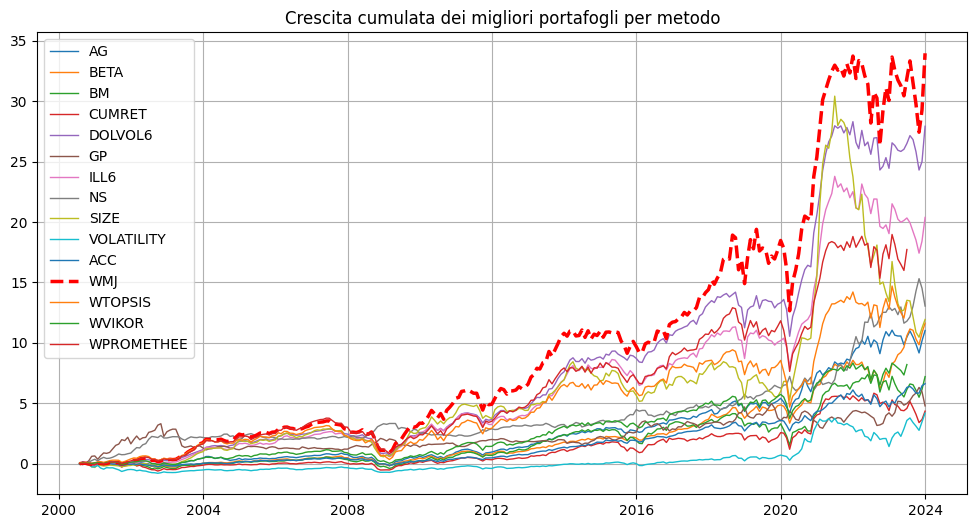

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for metodo, info in best_wportfolios.items():
    serie = weighted_portfolios[metodo][info['portafoglio']]
    crescita = (1 + serie).cumprod() - 1

    if metodo.lower() == 'wmj':
        plt.plot(crescita, label=metodo.upper(), color='red', linewidth=2.5, linestyle='--')
    else:
        plt.plot(crescita, label=metodo.upper(), linewidth=1)

plt.legend()
plt.title('Crescita cumulata dei migliori portafogli per metodo')
plt.grid(True)
plt.show()
